In [1]:
from typing import (Tuple, List, Dict, Union, Callable)
import pandas as pd
import numpy as np
import functools
from tqdm.notebook import tqdm
from scr.activation_funcs import identity, ReLU, sign, tanh
from scr.binary_operators import add, diff, get_x, get_y, multiple, x_is_greater_than_y
import matplotlib.pyplot as plt

In [2]:
# import torch
# from torch.nn import (Tanh,ReLU)

# def dynamics(y_t:torch.tensor,sigma):

#     a,b = y_t
#     y_next = torch.zeros_like(y_t)
#     size = y_t.shape[1]
#     relu = ReLU()

#     y_next[0] =  1.0 * torch.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * relu(torch.minimum(a,b)) + sigma * torch.randn(size)
#     y_next[1] = 0.6 * torch.sign(b) + 0.5 * a * b - 1.0 * torch.maximum(a,b) + sigma * torch.randn(size)

#     return y_next

# sigma_true = 0.1

# T_total = 2000
# y = torch.zeros((2, T_total))
# y_without_noise = torch.zeros((2, T_total))

# name_stock = dynamics(y,sigma_true)
# noise = dynamics(name_stock,0)

# # Nomura = name_stock[0]
# # PFN = name_stock[1]
# name_stock[:,0] = torch.tensor([0.5,0.5])
# noise[:,0] = torch.tensor([0.5,-0.5])
# name_stock_label = ["Nomura", "PFN"]

# plt.figure(figsize=(18,5))
# plt.xlim([T_total-100,T_total])
# plt.plot(name_stock[0].numpy(), color = "#cc0000", label = name_stock_label[0])
# plt.plot(name_stock[1].numpy(), color = "#083090", label = name_stock_label[1])
# plt.plot(noise[0].numpy(), color = "#cc0000", linestyle = "--", label = name_stock_label[0] + "(w/o noise)")
# plt.plot(noise[1].numpy(), color = "#083090", linestyle = "--", label = name_stock_label[1] + "(w/o noise)")
# plt.xlabel("time", fontsize = 18)
# plt.ylabel("y", fontsize = 18)
# plt.legend()

In [2]:
def dynamics(y_t: np.ndarray, sigma: float):

    a, b = y_t
    y_next = np.zeros_like(y_t)
    size = y_t.shape[1]

    y_next[0] = 1.0 * np.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * ReLU(
        np.minimum(a, b)) + sigma * np.random.randn(size)
    y_next[1] = 0.6 * np.sign(b) + 0.5 * a * b - 1.0 * np.maximum(
        a, b) + sigma * np.random.randn(size)

    return y_next


T_total = 2000
sigma = 0.1
y = np.zeros((2, T_total))
data = dynamics(y, sigma)


In [250]:
from collections import defaultdict


class Trader():
    def __init__(self,
                 num_stock: int,
                 num_factors_max: int,
                 max_lag: int,
                 activation_funcs: List[Callable],
                 binary_operators: List[Callable],
                 time_window: int = None,
                 seed:int=None) -> None:

        # set hyperparameters
        self.num_stock: int = num_stock  # 股票个数
        self.num_factors_max: int = num_factors_max  # 最大因子数
        self.max_lag: int = max_lag  # 滞后数
        self.activation_funcs: List[Callable] = activation_funcs  # 激活函数
        self.binary_operators: List[Callable] = binary_operators  # 二元操作符
        # if time_window==None, train by using all data
        self.time_window: int = time_window

        # GMM字典
        self.dict_activation: Dict = dict(
            zip(activation_funcs, range(len(activation_funcs))))

        self.dict_binary: Dict = dict(
            zip(binary_operators, range(len(binary_operators))))
        
        self.initialize_trader_params(seed)
        
    def initialize_trader_params(self, seed: int = None) -> None:

        # 是否设置随机数种子
        if seed:

            np.random.seed(seed)

        # X支股票选择N个factors
        self.num_factors: np.ndarray = np.random.choice(
            range(self.num_factors_max), self.num_stock)

        self.w: List[np.ndarray] = [
            np.random.randn(np.max([i, 1])) for i in self.num_factors
        ]
        self.X_factors: defaultdict = defaultdict(np.array)
        self.cumulative_error: np.ndarray = np.zeros(self.num_stock)
      
        # 设置参数 self.params[0] 表示第1支股票的所有参数信息
        self.params = [
            [
                np.random.choice(self.max_lag, i),  # D
                np.random.choice(self.max_lag, i),  # F
                np.random.choice(self.num_stock, i),  # P
                np.random.choice(self.num_stock, i),  # Q
                np.random.choice(self.activation_funcs, i),  # active_func
                np.random.choice(self.binary_operators, i),  # binary_operator
            ] for i in self.num_factors
        ]

    def calc_factors(self, istock: int, data: np.ndarray) -> np.ndarray:

        stock_params = np.vstack(self.params[istock]).T

        def _calc_factor(params: np.ndarray) -> float:

            D, F, P, Q, active_func, binary_operator = params

            return active_func(
                binary_operator(data[P][self.max_lag - D],
                                data[Q][self.max_lag - F]))

        return np.array([_calc_factor(row) for row in stock_params])

    def get_x_factors(self, istock: int, data: np.ndarray) -> None:

        size = data.shape[1]

        self.X_factors[istock] = np.vstack([
            self.calc_factors(istock, data[:, t - self.max_lag - 1:t])
            for t in range(self.max_lag + 1, size)
        ])

    def learn(self,istock:int, y:np.ndarray) -> None:
        
        epsilon = 0.0001
        X = self.X_factors[istock]
        
        if _check_singular(X,self.num_factors[istock]):
            
            self.w[istock] = np.zeros(len(self.w[istock]))
            
        else:
            
            self.w[istock] = np.linalg.inv(X.T.dot(X) + epsilon).dot(
                X.T).dot(y)
    
    # 对test data进行测试，并在此基础上对模型进行评估．
    def predict(self) -> np.ndarray:
        """ 使用最新的factors预测来预测下一个时间
        """
        
        y_pred: np.ndarray = np.array([
            self.X_factors[i_stock][-1].dot(self.w[i_stock])
            for i_stock in range(self.num_stock)
        ])
        
        return y_pred
    
    def _predict_all(self) -> np.ndarray:
        """ len(X_factors) < time_window时出错"""
        
        y_preds: np.ndarray = np.array([
            self.X_factors[i_stock].dot(self.w[i_stock])
            for i_stock in range(self.num_stock)
        ])
        return y_preds
    
    def calc_cumulative_error(self, y_true:np.ndarray):
        
        y_preds:np.ndarray = self._predict_all()
        
        errors: float = np.square(y_preds - y_true)
        
        errors = np.sqrt(errors.mean(axis=1))
        
        print(errors)
        for i_stock in range(self.num_stock):
            print(i_stock)
            self.cumulative_error[i_stock] = errors[i_stock]
            
        return self.cumulative_error
        
def _check_singular(arr:np.ndarray,n:int) -> bool:
    """用奇异值分解方法求阵列的矩阵秩"""
    return np.linalg.matrix_rank(arr.T.dot(arr)) < n

In [251]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y
]

stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4
seed = 42
trader = Trader(len(stock_names), num_factors_max, delay_time_max,
                activation_funcs, binary_operators, time_window,seed)

trader.get_x_factors(0,data[:,:100])
trader.get_x_factors(1,data[:,:100])

trader.learn(0,data[0,3:100])
trader.learn(1,data[1,3:100])

In [252]:
trader.calc_cumulative_error(data[:,3:100])

[0.09251576 0.09219666]
0
1


array([0.09251576, 0.09219666])

In [7]:
# 如果有N个交易员则调用create_formulae生成一组formulae
def create_formulae(M: int,
                    A: List[Callable],
                    O: List[Callable],
                    stock_num: int,
                    max_lag: int = 9,
                    l: int = 1,
                    seed: int = None) -> List[Callable]:
    """构造$\Theta$
       $\Theta=\sum^{M}_{j}w_{j}A_{j}(O_{j}(r_{P_{j}}[t-D_{j}],r_{Q_{j}}[t-F_{j}]))$
       
    Args:
        M (int): 每位交易员表达式最大项数
        A (List[Callable]): 激活函数列表
        O (List[Callable]): 二元操作符函数列表
        stock_num (int): 股票个数
        max_lag (int, optional): 数据延迟最大取值. Defaults to 9.
        l (int, optional): 交易延迟量,即观察到数据后不可能立马进行交易,需要等待l时间. Defaults to 1.
        seed (int, optional): 随机数种子. Defaults to None.

    Returns:
        List: _description_
    """
    def _formula_func(data: np.ndarray, active_func: callable,
                      binary_oper: Callable, P: int, Q: int, F: int,
                      D: int) -> float:
        """_summary_

        Args:
            data (np.ndarray): 传入数据0轴为股票 1为时间

        """
        t = data.shape[1] # 获取时间长度
        # print('t=%s'%t)
        # print('D=%s,F=%s'%(D,F))
        # print('P=%s,Q=%s'%(P,Q))
        # print('active_func:%s,binary_oper:%s'%(active_func.__name__,binary_oper.__name__))
        # print(data)
        # print(data[P][t - D], data[Q][t - F])
 
        if (t-D < 0) or (t-F < 0):
            raise ValueError('t-D或t-F不能小于0,t=%s,D=%s,F=%s'%(t,D,F))
        
        indices:np.ndarray = np.arange(max_lag + l, t)
        
        x:np.ndarray = np.take(data[P],
            indices - D)
        
        y:np.ndarray = np.take(data[Q],
            indices - F)
        
        # return active_func(binary_oper(data[P][t - D], data[Q][t - F]))
        print(binary_oper.__name__)
        return active_func(binary_oper(x, y))

    if seed:

        np.random.seed(seed)

    m = np.random.choice(M)  # 根据M最大项数选择个数

    # 构建延迟数
    a = np.arange(1,max_lag + l + 1) # 最少之后为1天
    D: np.ndarray = np.random.choice(a, m)
    F: np.ndarray = np.random.choice(a, m)
    
    # 随机选择股票
    P: np.ndarray = np.random.choice(stock_num, m)
    Q: np.ndarray = np.random.choice(stock_num, m)

    # 列表中存放构成公式的"算子"
    formulae: np.ndarray = np.array(
        [np.random.choice(A, m),
         np.random.choice(O, m), P, Q, D, F],
        dtype='object').T

    # 列表中的func后续近仅需要传入data及对应的T即可得到返回值
    formulae_ls_func: List[Callable] = [
        functools.partial(_formula_func,
                          active_func=row[0],
                          binary_oper=row[1],
                          P=row[2],
                          Q=row[3],
                          F=row[4],
                          D=row[5]) for row in formulae
    ]

    return formulae_ls_func

In [8]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y
]

# 一位trader的Theta
formulate = create_formulae(10,activation_funcs,binary_operators,stock_num=2,max_lag=2,l=1,seed=42)

In [9]:
# t最少为max_lag+l+1

In [10]:
ls = []

for i,func in enumerate(formulate):
    
   print(i,len(func(data)))


get_x
0 1997
multiple
1 1997
diff
2 1997
max


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
class Company():
    def __init__(self,
                 stock_names: List[str],
                 num_factors_max: int,
                 delay_time_max: int,
                 activation_funcs: List[Callable],
                 binary_operators: List[Callable],
                 num_traders: int,
                 Q: float = 0.2,
                 time_window: int = None,
                 seed:int = None,
                 how_recruit: str = "random") -> None:

        self.stock_names: List[str] = stock_names
        self.num_stock: int = len(stock_names)
        self.num_factors_max: int = num_factors_max
        self.delay_time_max: int = delay_time_max
        self.activation_funcs: List[Callable] = activation_funcs
        self.binary_operators: List[Callable] = binary_operators
        self.num_traders: int = num_traders
        self.Q: float = Q
        # if time_window==None, train by using all data
        self.time_window: int = time_window
        self.how_recruit: str = how_recruit

        # 初始化trader
        self.traders = [
            Trader(self.num_stock, self.num_factors_max, self.delay_time_max,
                   self.activation_funcs, self.binary_operators,
                   self.time_window)
        ] * self.num_traders
    
    def find_bad_traders(self, y_true:np.ndarray, Q:float):
        """ 找出错误率低于前Q%的交易员"""

        for trader in self.traders:
            
            trader.calc_cumulative_error(y_true)
            
        cumulative_errors = np.zeros((self.num_stock, self.num_traders))
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                self.traders[i_trader].calc_cumulative_error(y_true)
                cumulative_errors[i_stock][i_trader] = self.traders[
                    i_trader].cumulative_error[i_stock]

        bad_traders = np.ones((self.num_stock, self.num_traders)) > 0.0
        for i_stock in range(self.num_stock):
            bad_traders[i_stock] = cumulative_errors[i_stock] > np.percentile(
                cumulative_errors[i_stock], 100. * Q)
        return bad_traders

In [225]:
np.zeros((3,4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [125]:
from sklearn import mixture, preprocessing


class Company:
    def __init__(self,
                 stock_names: List[str],
                 num_factors_max: int,
                 delay_time_max: int,
                 activation_funcs: List[Callable],
                 binary_operators: List[Callable],
                 num_traders: int,
                 Q: float = 0.2,
                 time_window: int = None,
                 how_recruit: str = "random"):
        
        """time_window应该大于num_factors_max

            1-q 代表bad_traders的百分比,也就是说Q越大,被解雇的百分比就越小.(Q即存活率)

            我试过把所有人都变成坏人，但没有意义
        """
        self.stock_names: List[str] = stock_names
        self.num_stock: int = len(stock_names)
        self.num_factors_max: int = num_factors_max
        self.delay_time_max: int = delay_time_max
        self.activation_funcs: List[Callable] = activation_funcs
        self.binary_operators: List[Callable] = binary_operators
        self.num_traders: int = num_traders
        self.Q: float = Q
        # if time_window==None, train by using all data
        self.time_window: int = time_window
        self.how_recruit: str = how_recruit

        self.df_y_train: pd.DataFrame = None

        self.initialize_traders()  # 初始化trader

    def fit(self, df_y_train: pd.DataFrame):
        if self.df_y_train is not None:
            raise ValueError("df_y_train不能为空")

        self.df_y_train = df_y_train
        y_train: np.ndarray = self.df_y_train.T.values

        for t in tqdm(range(self.delay_time_max + 1, len(self.df_y_train))):
            data_to_stack = y_train[:, t - self.delay_time_max - 1:t]

            self.observe(data_to_stack)

            if self.delay_time_max + 1 + self.time_window < t <= len(
                    self.df_y_train):
                y_true = y_train[:, t - self.time_window + 1:t + 1]
                self.educate(y_true)
                self.fire_and_recruit(t, y_true)

        # 最后一个时刻 t 的数据显示educate只能是 stock，因为没有 t + 1的数据可用
        # stock否则我们在用 self.agomez 预测时会用到 t-1的数据来预测时间 t
        data_to_stack = y_train[:, t - self.delay_time_max:t + 1]
        self.observe(data_to_stack)

    def fit_new_data(self, dict_y, tuning=False):
        # 最初にdf_y_trainにデータを追加。この時点では計算されていない。
        self.add_new_data(dict_y)

        # tuning=Trueであれば、新しいデータを使用して再度educate&fire_recruitを実施する
        if tuning:
            self.educate_fire_recruit_by_new_data()

        # 新しいデータを用いてfactorを計算する
        self.observe_new_data()

    def add_new_data(self, dict_y):
        self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)

    def educate_fire_recruit_by_new_data(self):
        # 一番最新のデータから教育
        t = len(self.df_y_train)
        y_train = self.df_y_train.T.values
        y_true = y_train[:, t - self.time_window:t]
        self.educate(y_true)
        self.fire_and_recruit(t - 1, y_true)

    def observe_new_data(self):
        # 一番最新のデータをobserve
        t = len(self.df_y_train)
        y_train = self.df_y_train.T.values
        data_to_stack = y_train[:, t - self.delay_time_max - 1:t]
        self.observe(data_to_stack)

    def initialize_traders(self):
        """初始化Trader"""

        model = Trader(self.num_stock, self.num_factors_max,
                       self.delay_time_max, self.activation_funcs,
                       self.binary_operators, self.time_window)

        self.traders = [model] * self.num_traders

    def generate_trader_without_singular_initialize_params(
            self, i_trader, i_stock, t):
        y_train = self.df_y_train.T.values
        for i_stock in range(self.num_stock):
            self.traders[i_trader].reset_params(i_stock)
            for idx in reversed(range(self.time_window)):
                self.traders[i_trader].stack_factors(
                    y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                    i_stock)
            while self.traders[i_trader]._check_rank_deficient(i_stock):
                self.traders[i_trader].reset_params(i_stock)
                for idx in reversed(range(self.time_window)):
                    self.traders[i_trader].stack_factors(
                        y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                        i_stock)

    def generate_trader_without_singular(self, i_trader, i_stock, t,
                                         vbgmm_num_factor,
                                         vbgmm_factor_params):

        y_train = self.df_y_train.T.values
        for i_stock in range(self.num_stock):
            list_params = self.sample_params(vbgmm_num_factor,
                                             vbgmm_factor_params)
            self.traders[i_trader].set_params(i_stock, list_params)
            for idx in reversed(range(self.time_window)):
                self.traders[i_trader].stack_factors(
                    y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                    i_stock)
            while self.traders[i_trader]._check_rank_deficient(i_stock):
                list_params = self.sample_params(vbgmm_num_factor,
                                                 vbgmm_factor_params)
                self.traders[i_trader].set_params(i_stock, list_params)
                for idx in reversed(range(self.time_window)):
                    self.traders[i_trader].stack_factors(
                        y_train[:, t - self.delay_time_max - 1 - idx:t - idx],
                        i_stock)

    def observe(self, data: List):
        """计算factors并保存所有trader的排名
        """
        # for i_trader in range(self.num_traders):
        #     for i_stock in range(self.num_stock):
        #         self.traders[i_trader].stack_factors(data, i_stock)

        for trader in self.traders:

            for i_stock in range(self.num_stock):

                trader.stack_factors(data, i_stock)

    def educate(self, y_true):
        """ 训练错误率低于底层Q%的交易员"""

        bad_traders = self.find_bad_traders(y_true, 1 - self.Q)
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if bad_traders[i_stock][i_trader]:
                    self.traders[i_trader].learn(y_true[i_stock], i_stock)

    def find_bad_traders(self, y_true, Q):
        """ 找出错误率低于前Q%的交易员"""

        cumulative_errors = np.zeros((self.num_stock, self.num_traders))
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                self.traders[i_trader].calc_cumulative_error(y_true)
                cumulative_errors[i_stock][i_trader] = self.traders[
                    i_trader].cumulative_error[i_stock]

        bad_traders = np.ones((self.num_stock, self.num_traders)) > 0.0
        for i_stock in range(self.num_stock):
            bad_traders[i_stock] = cumulative_errors[i_stock] > np.percentile(
                cumulative_errors[i_stock], 100. * Q)
        return bad_traders

    def fire_and_recruit(self, t, y_true):
        """ 解雇、补充错误率低于前Q% 的交易员"""

        if self.how_recruit == "gmm":
            list_vbgmm = []
            good_traders = ~self.find_bad_traders(y_true, 1 - self.Q)
            for i_stock in range(self.num_stock):
                list_vbgmm.append(self.fit_vbgmm(i_stock, good_traders))

        bad_traders = self.find_bad_traders(y_true, self.Q)
        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if bad_traders[i_stock][i_trader]:
                    if self.how_recruit == "gmm":
                        self.generate_trader_without_singular(
                            i_trader, i_stock, t, list_vbgmm[i_stock][0],
                            list_vbgmm[i_stock][1])
                    else:
                        self.generate_trader_without_singular_initialize_params(
                            i_trader, i_stock, t)
                    self.traders[i_trader].calc_cumulative_error(y_true)

    def sample_params(self, vbgmm_num_factor, vbgmm_factor_params):
        list_params = []
        num_factor = np.vectorize(round)(vbgmm_num_factor.sample(1)[0][0])[0]
        num_factor = self.check_param(num_factor, 1, self.num_factors_max)
        list_params.append({"num_factor": num_factor})
        for i_factor in range(num_factor):
            factor_params = np.vectorize(round)(
                vbgmm_factor_params.sample(1)[0])[0]
            dict_params = {}
            for key, value in zip([
                    "delay_P", "delay_Q", "stock_P", "stock_Q",
                    "activation_func", "binary_operator"
            ], factor_params):
                if key in ["delay_P", "delay_Q"]:
                    dict_params[key] = self.check_param(
                        value, 0, self.delay_time_max - 1)
                elif key in ["stock_P", "stock_Q"]:
                    dict_params[key] = self.check_param(
                        value, 0, self.num_stock - 1)
                elif key == "activation_func":
                    dict_params[key] = self.check_param(
                        value, 0,
                        len(self.activation_funcs) - 1)
                elif key == "binary_operator":
                    dict_params[key] = self.check_param(
                        value, 0,
                        len(self.binary_operators) - 1)
            list_params.append(dict_params)
        return list_params

    def check_param(self, param_, min_, max_):
        if param_ < min_:
            param_ = min_
        elif param_ > max_:
            param_ = max_
        else:
            param_ = param_
        return param_

    def fit_vbgmm(self, i_stock, good_traders):
        """ good_traders[i_stock]のTraderのパラメータのみでFittingする
        """
        df_num_factor = pd.DataFrame(columns=["num_factor"])
        df_factor_params = pd.DataFrame(columns=[
            "delay_P", "delay_Q", "stock_P", "stock_Q", "activation_func",
            "binary_operator"
        ])
        for i_trader, trader in enumerate(self.traders):
            if good_traders[i_stock][i_trader]:
                list_params = trader.get_params(i_stock)
                dict_num_factor = list_params[0]
                df_num_factor = df_num_factor.append(dict_num_factor,
                                                     ignore_index=True)

                for i_factor in range(dict_num_factor["num_factor"]):
                    dict_factor_params = list_params[i_factor + 1]
                    df_factor_params = df_factor_params.append(
                        dict_factor_params, ignore_index=True)
        print(df_factor_params)
        vbgmm_num_factor = self.VBGMM(df_num_factor,
                                      n_components=self.num_stock)
        vbgmm_factor_params = self.VBGMM(df_factor_params, n_components=3)

        return vbgmm_num_factor, vbgmm_factor_params

    def VBGMM(self, X, n_components=10):
        model = mixture.BayesianGaussianMixture(n_components=n_components)
        return model.fit(X)

    def aggregate(self):
        predictions = np.zeros((self.num_stock, self.num_traders))
        weights = np.zeros((self.num_stock, self.num_traders))

        bad_traders = np.ones((self.num_stock, self.num_traders)) > 0.0
        for i_stock in range(self.num_stock):
            cumulative_errors = np.array(
                [trader.cumulative_error[i_stock] for trader in self.traders])
            bad_traders[i_stock] = cumulative_errors > np.percentile(
                cumulative_errors, 100. * self.Q)

        for i_trader in range(self.num_traders):
            for i_stock in range(self.num_stock):
                if not bad_traders[i_stock][
                        i_trader]:  # Q-パーセンタイル以上の成績の良いTraderのみを対象
                    weights[i_stock][i_trader] = (
                        1.0 / self.traders[i_trader].cumulative_error[i_stock])
                    predictions[i_stock][i_trader] = self.traders[
                        i_trader].predict()[i_stock]

        predictions_weighted = np.zeros(self.num_stock)
        for i_stock in range(self.num_stock):
            predictions_weighted[i_stock] = (weights[i_stock] *
                                             predictions[i_stock]).sum() / (
                                                 weights[i_stock].sum())
        return predictions_weighted


# 设置数据

In [129]:
def create_dataset(T, sigma_t):
    def simulation(y_t, sigma):
        y_t1 = np.zeros(2)
        y_t1[0] = 1.0 * tanh(
            y_t[0]) + 0.8 * y_t[0] * y_t[1] + 1.0 * y_t[1] - 1.0 * ReLU(
                min(y_t[0], y_t[1])) + sigma * np.random.randn()
        y_t1[1] = +0.6 * sign(y_t[1]) + 0.5 * y_t[0] * y_t[1] - 1.0 * max(
            y_t[0], y_t[1]) + sigma * np.random.randn()
        return y_t1

    y = np.zeros((2, T))
    y_without_noise = np.zeros((2, T))
    y[:, 0] = np.array([0.1, 0.1])
    y_without_noise[:, 0] = np.array([0.1, 0.1])

    for t in range(1, T):
        y[:, t] = simulation(y[:, t - 1], sigma_t)
        y_without_noise[:, t] = simulation(y[:, t - 1], 0.0)

    plt.plot(y[0], color="#cc0000", label="stock0")
    plt.plot(y[1], color="#083090", label="stock1")
    plt.plot(y_without_noise[0],
             color="#cc0000",
             linestyle="--",
             label="stock0" + "(w/o noise)")
    plt.plot(y_without_noise[1],
             color="#083090",
             linestyle="--",
             label="stock1" + "(w/o noise)")
    plt.xlabel("time", fontsize=18)
    plt.ylabel("y", fontsize=18)
    plt.xlim([T - 100, T])
    plt.legend()
    plt.show()
    plt.close()

    return y, y_without_noise

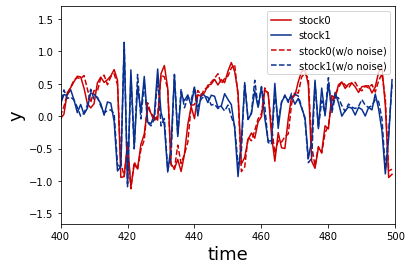

In [130]:
sigma = 0.1
T_total = 500
y, y_without_noise = create_dataset(T_total, sigma)

In [131]:
df_y = pd.DataFrame(y, index=["stock0", "stock1"]).T

df_y.head()

,stock0,stock1
0,0.100000,0.100000
1,0.053854,0.370332
2,0.399678,0.297852
3,0.550409,0.239128
4,0.716086,0.097627


# 训练

In [134]:
activation_funcs = [identity, ReLU, sign, tanh]
binary_operators = [
    max, min, add, diff, multiple, get_x, get_y, x_is_greater_than_y
]

stock_names = ["stock0", "stock1"]
time_window = 200
delay_time_max = 2
num_factors_max = 4

model = Company(stock_names,
                num_factors_max,
                delay_time_max,
                activation_funcs,
                binary_operators,
                num_traders=40,
                Q=0.2,
                time_window=time_window,
                how_recruit="random")

In [135]:
T_train = 400
df_y_train = df_y.iloc[:T_train, :]
df_y_test = df_y.iloc[T_train:, :]

In [136]:
model.fit(df_y_train)

  0%|          | 0/397 [00:00<?, ?it/s]

[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.37033219 0.29785199]]
[[0.1        0.05385383 0.39967812]
 [0.1        0.

In [32]:
model.aggregate()

array([0.01194506, 0.        ])

In [39]:
model.traders[0].w

[array([0.02347847]), array([0.32984757])]

In [171]:
# for i,trader_model in enumerate(model.traders):

#     print(i,len(trader_model.num_factors))

# 测试

In [33]:
errors_test_notuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_notuning.append(np.abs(row.values - prediction_test))

    # tuning==Falseの場合、データが追加されても重みの更新などパラメータは変わらない
    model.fit_new_data(row.to_dict(), tuning=False)

errors_test_tuning = []
for i, row in tqdm(df_y_test.iterrows()):
    prediction_test = model.aggregate()
    errors_test_tuning.append(np.abs(row.values - prediction_test))

    # tuning==Trueの場合、データが追加された際に重みの更新などパラメータが調整される
    model.fit_new_data(row.to_dict(), tuning=True)

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

0it [00:00, ?it/s]

C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_y_train = self.df_y_train.append(dict_y, ignore_index=True)
C:\Users\华思远\AppData\Local\Temp\ipykernel_23356\723388215.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [34]:
days_ma = 5

# trader-company errors with no-tuning
errors_test_notuning = np.array(errors_test_notuning)
errors_test_notuning_ma = pd.DataFrame(errors_test_notuning).rolling(
    days_ma).mean()

# trader-company errors with tuning
errors_test_tuning = np.array(errors_test_tuning)
errors_test_tuning_ma = pd.DataFrame(errors_test_tuning).rolling(
    days_ma).mean()

# baseline method
errors_baseline = np.abs(y[:, T_train + 1:] - y[:, T_train:-1])
errors_baseline_ma = pd.DataFrame(errors_baseline.T).rolling(days_ma).mean()

# lower bound
errors_lower_bound = np.abs(y[:, T_train + 1:] -
                            y_without_noise[:, T_train + 1:])
errors_lower_bound_ma = pd.DataFrame(
    errors_lower_bound.T).rolling(days_ma).mean()


stock0


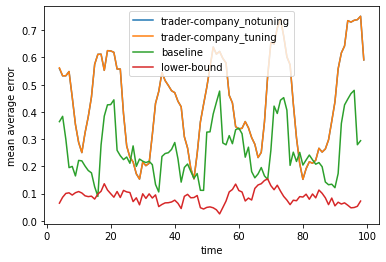

stock1


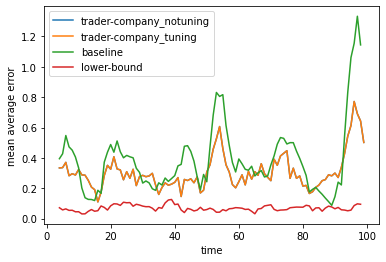

In [36]:
for i_stock, name in enumerate(stock_names):
    print(name)
    plt.plot(errors_test_notuning_ma[i_stock], label="trader-company_notuning")
    plt.plot(errors_test_tuning_ma[i_stock], label="trader-company_tuning")
    plt.plot(errors_baseline_ma[i_stock], label="baseline")
    plt.plot(errors_lower_bound_ma[i_stock], label="lower-bound")
    plt.xlabel("time")
    plt.ylabel("mean average error")
    plt.legend()
    plt.show()